[Git](https://github.com/Daniil-Selikhanovych/bnn-vi)

[On the Expressiveness of Approximate Inference in Bayesian Neural Networks](https://arxiv.org/pdf/1909.00719.pdf)

[Sufficient Conditions for Idealised Models to Have No
Adversarial Examples: a Theoretical and Empirical
Study with Bayesian Neural Networks](https://arxiv.org/pdf/1806.00667.pdf)

[Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf)

[Neural Networks as Gaussian Process](https://arxiv.org/pdf/1711.00165.pdf)

[VAE in Pyro](https://pyro.ai/examples/svi_part_i.html)

[Neural Networks in Pyro](http://docs.pyro.ai/en/stable/nn.html)

[Bayessian Regression in Pyro](https://pyro.ai/examples/bayesian_regression_ii.html?highlight=sample)

[Intro to HMC](https://arxiv.org/pdf/1206.1901.pdf)

[Stochastic HMC](https://arxiv.org/pdf/1402.4102.pdf)

[Pyro: Trace](http://docs.pyro.ai/en/stable/poutine.html?highlight=stochastic#pyro.poutine.Trace.stochastic_nodes)

[Variational Dropout and
the Local Reparameterization Trick](https://arxiv.org/pdf/1506.02557.pdf)

![details1](../img/description1.png)
![details2](../img/description2.png)

In [1]:
import os, sys
import random
import copy
from itertools import islice
from functools import partial
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset

import pyro
from pyro.infer import (SVI, Trace_ELBO, TraceMeanField_ELBO,
                        MCMC, NUTS, Predictive
                       )
from pyro.infer.autoguide import (AutoNormal, AutoDiagonalNormal, 
                                  AutoMultivariateNormal
                                 )
from pyro.optim import Adam

In [2]:
rcParams.update({'font.size': 12})

In [3]:
if '..' not in sys.path:
    sys.path.append('..')

In [4]:
%load_ext autoreload
%autoreload 1

%aimport bnn_vi.data_sampling, bnn_vi.models, bnn_vi.plotting
from bnn_vi.data_sampling import (CircleDataset,
                                  get_rotation,
                                  get_sample_regression
)
from bnn_vi.models import (Multilayer,
                           MultilayerBayesian,
                           ModelGenerator,
                           EstimatorPool
)
from bnn_vi.plotting import (ProgressPlotter,
                             plot_1D,
                             plot_2D
                         )

torch.manual_seed(42);

In [5]:
N_WORKERS = 0 if os.name != 'nt' else 0# no threads for windows :c
if torch.cuda.is_available():
    print("Using CUDA!")
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    print("Using CPU!")
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Using CPU!


In [6]:
DEVICE = torch.device('cpu')
IS_CUDA = False

In [7]:
N_SAMPLES = 100

In [13]:
circles = CircleDataset(N_SAMPLES, 2, sigma=0.2, ysigma=0.1, include_zero=False)
circles = TensorDataset(circles.data @ get_rotation(-45),
                           circles.target[:, 0])

In [14]:
(x_reg, y_reg), (x_true, y_true) = get_sample_regression(N_SAMPLES)
regression = TensorDataset(x_reg, y_reg)

In [15]:
data = circles
# data = regression

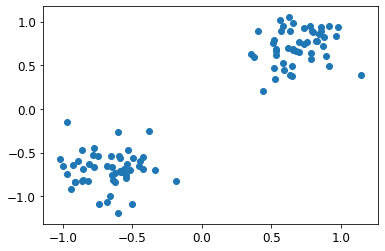

In [16]:
plt.scatter(data.tensors[0][:, 0], data.tensors[0][:, 1])

In [20]:
pyro.set_rng_seed(1)

BATCH_SIZE = len(data)
N_EPOCHS = 10**5
log_per = 500

data_loader = DataLoader(data, batch_size=BATCH_SIZE, pin_memory=IS_CUDA,
                         shuffle=True, num_workers=N_WORKERS)

params = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 50,
    'n_layers': 1,
    'dropout': None,
    'device': DEVICE
}
target_std = 1e-1

model = Multilayer(**params)
model_b = MultilayerBayesian(**params, target_std=target_std)
gen = ModelGenerator(Multilayer, **params)

{'params': {'guide.loc': Parameter containing:
tensor([-3.5606e-02, -4.5847e-02,  4.6848e-02, -8.2753e-02,  2.1691e-02,
         3.1669e-03,  6.0846e-03, -3.8576e-02, -4.1400e-02,  3.7837e-02,
        -3.1299e-02, -7.3373e-02,  4.3031e-02,  8.9522e-02, -6.6706e-02,
        -1.4947e-01, -9.4195e-02, -6.9569e-02,  1.5317e-01,  7.6083e-02,
        -1.0531e-01,  6.6050e-02, -2.5355e-02,  2.4221e-02,  9.2014e-02,
        -1.2268e-02,  8.7567e-04, -9.1853e-02,  3.9379e-02,  1.1346e-02,
        -1.8822e-01,  1.0457e-01, -3.0288e-03, -8.4744e-02,  8.1772e-02,
        -3.5590e-02,  3.0460e-04,  9.5790e-02, -4.7456e-02, -6.8845e-02,
        -2.4032e-02, -8.8158e-02, -1.6668e-01, -5.2873e-02, -1.0107e-01,
        -2.1903e-02, -5.0504e-02, -2.1367e-02,  4.3237e-02,  9.5585e-02,
        -3.1627e-02, -1.2173e-01, -4.7232e-02, -2.8863e-02, -1.0308e-01,
        -6.2386e-02, -2.6521e-02, -9.6634e-02,  9.9034e-02,  9.3041e-04,
         1.8189e-01,  5.1178e-02,  9.7822e-02,  1.7276e-02,  4.6604e-03,
    

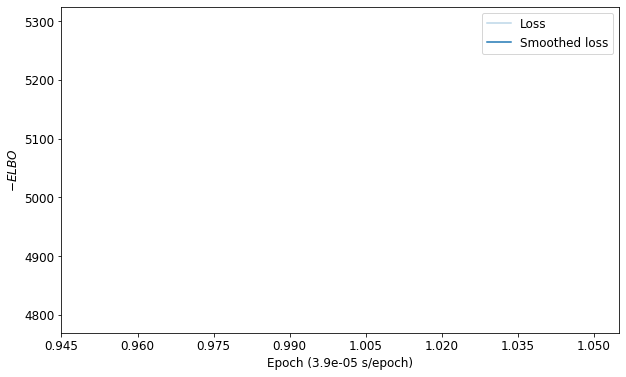

PicklingError: Can't pickle <class 'bnn_vi.models.MultilayerBayesian'>: it's not the same object as bnn_vi.models.MultilayerBayesian

In [19]:
fig, losses = model_b.train(data_loader, N_EPOCHS, num_particles=1, lr=1e-2, show_smooth=True,
                            log_per=log_per, save_per=10*log_per)
fig.savefig("1layer_2d_VI_loss.pdf")

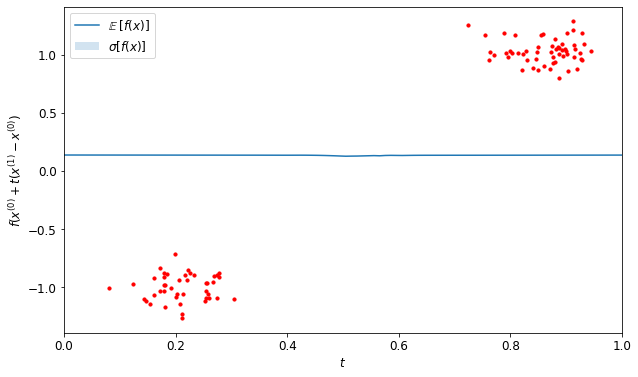

In [14]:
start, _ = data.tensors[0].min(dim=0)
end, _ = data.tensors[0].max(dim=0)

fig = plot_1D(start.numpy(), end.numpy(),
              model_b.get_mean_std, num_points=100,
              data=(data.tensors[0], data.tensors[1]), mode='class')
fig.savefig("1layer_2d_VI.pdf")

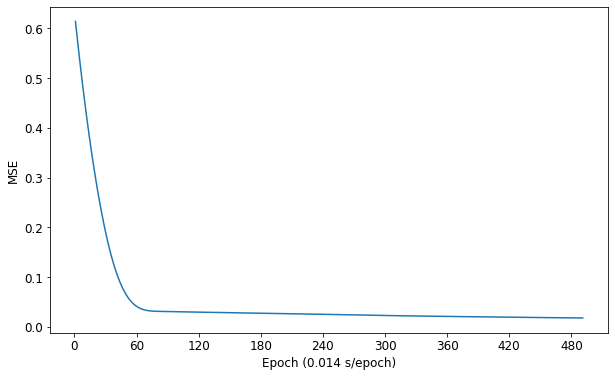

In [18]:
fig, losses = model.train(data_loader, 500, log_per=10, show_smooth=False)
fig.savefig("1layer_2d_det_loss.pdf")

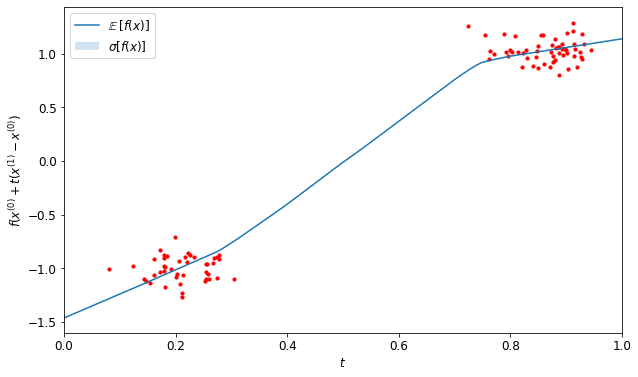

In [19]:
start, _ = data.tensors[0].min(dim=0)
end, _ = data.tensors[0].max(dim=0)

fig = plot_1D(start.numpy(), end.numpy(),
              model.get_mean_std, num_points=100,
              data=(data.tensors[0], data.tensors[1]), mode='class')
fig.savefig("1layer_2d_det.pdf")

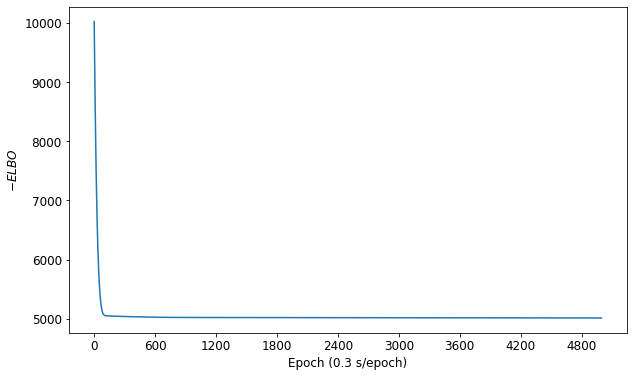

In [20]:
model_pr = MultilayerBayesian(**params)
model_pr.load_pretrained(model)
fig, losses = model_pr.train(data_loader, N_EPOCHS, lr=1e-3, num_particles=32, show_smooth=False)
fig.savefig("1layer_2d_VI_pr_loss.pdf")

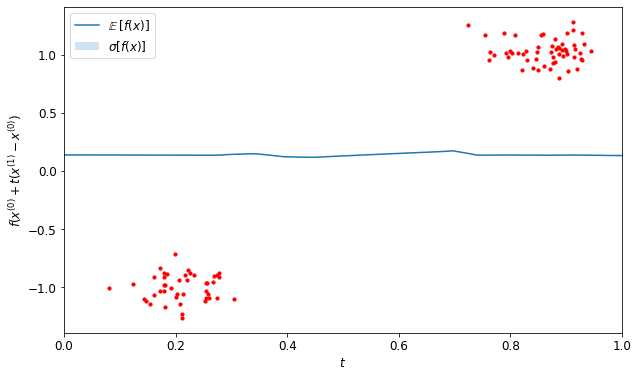

In [21]:
start, _ = data.tensors[0].min(dim=0)
end, _ = data.tensors[0].max(dim=0)

fig = plot_1D(start.numpy(), end.numpy(),
              model_pr.get_mean_std, num_points=100,
              data=(data.tensors[0], data.tensors[1]), mode='class')
fig.savefig("1layer_2d_pr.pdf")

In [22]:
plot_2D((-2, 2), (-2, 2), model_b.get_mean_std, num_points=100,
        data=circles.data)

AttributeError: 'TensorDataset' object has no attribute 'data'

## HMC

In [20]:
DO_LOAD = True

In [21]:
samples = None
if DO_LOAD:
    samples = torch.load('samples.pth', map_location='cpu')
else:
    pyro.clear_param_store()
    nuts_kernel = NUTS(model_b)

    mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50)
    mcmc.run(circles.data.float().to(DEVICE), circles.target[:, 0].float().to(DEVICE))
    samples = mcmc.get_samples()
    torch.save(samples, 'samples.pth')

In [40]:
samples = torch.load('samples.pth', map_location='cpu')
models = gen(samples)
pool = EstimatorPool(models)

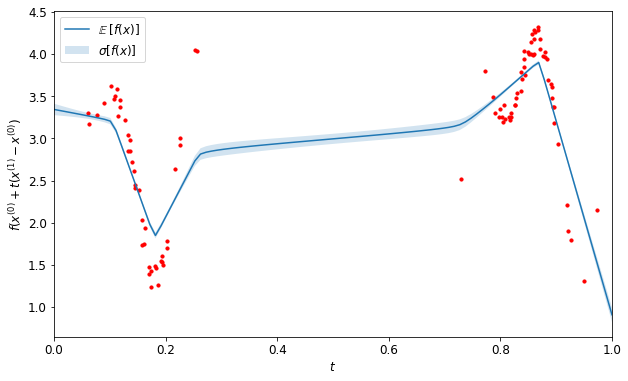

In [41]:
fig = plot_1D(np.array([-1,]), np.array([1,]), pool.get_mean_std, num_points=100,
              data=(x_reg[:, None], y_reg[:, None]))
fig.savefig('1layer_HMC.png')

In [42]:
plot_2D((-2, 2), (-2, 2), pool.get_mean_std, num_points=100,
        data=circles.data)

RuntimeError: size mismatch, m1: [32 x 2], m2: [1 x 50] at /opt/conda/conda-bld/pytorch_1587428207430/work/aten/src/TH/generic/THTensorMath.cpp:41

In [41]:
(x, y), (x_true, y_true) = get_sample_regression(BATCH_SIZE)

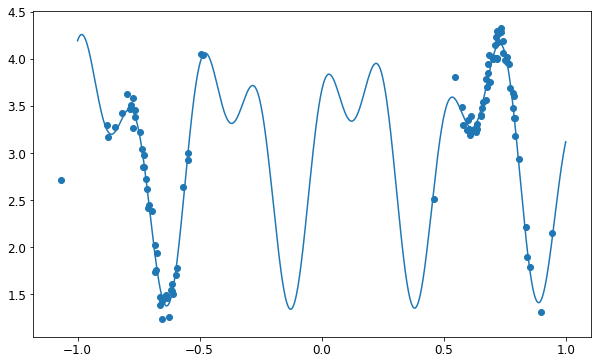

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(x_true, y_true)
ax.scatter(x, y)

plt.show()